### __Natural Language Processing: BERT Model__
> - https://www.kaggle.com/code/sanketsonu/bert-model-nlp-with-disaster-tweets

In [1]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official
!pip install tensorflow_hub

     |████████████████████████████████| 4.9 MB 8.0 MB/s 
     |████████████████████████████████| 462 kB 45.7 MB/s 
     |████████████████████████████████| 2.2 MB 7.6 MB/s 
     |████████████████████████████████| 237 kB 43.7 MB/s 
     |████████████████████████████████| 90 kB 9.0 MB/s 
     |████████████████████████████████| 99 kB 9.2 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 1.1 MB 42.1 MB/s 
     |████████████████████████████████| 1.2 MB 43.2 MB/s 
     |████████████████████████████████| 352 kB 54.4 MB/s 
     |████████████████████████████████| 636 kB 52.0 MB/s 
     |████████████████████████████████| 47.8 MB 55 kB/s 


In [2]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 8.9 MB/s 
     |████████████████████████████████| 895 kB 38.1 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 6.6 MB 26.2 MB/s 


In [3]:
import re
import numpy as np
import pandas as pd
import time

import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras import backend as K
from transformers import AutoTokenizer,TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy

sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#for showing 2D plot
%matplotlib inline    

# to be able to see multiple ouputs from sungle cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# import data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

train_df.info()
train_df

test_df.info()
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [7]:
# drop 'keyword' and 'location' columns
train_df = train_df.drop(['keyword','location'], axis = 1)
test_df = test_df.drop(['keyword','location'], axis = 1)
train_df.head(3)
test_df.head(3)

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1


,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."


In [8]:
# Checking Shape of Train and Test sets
print("Shape of Train set:", train_df.shape)
print("Shape of Test set:", test_df.shape)

Shape of Train set: (7613, 3)
Shape of Test set: (3263, 2)


In [9]:
# check target labels
df = train_df.copy()
df['target'].value_counts()
df['target'].value_counts()/len(df)

0    4342
1    3271
Name: target, dtype: int64

0    0.57034
1    0.42966
Name: target, dtype: float64

#### __Splitting data into Train and Test sets__

In [10]:
y = tf.keras.utils.to_categorical(df['target'], num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.2, random_state=3)

### __BERT Mocel__
#### _Base Model with Neural Networks:_

In [11]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/4")

In [12]:
# Checking array created using BERT:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

# quick test
get_sentence_embedding(["You are noob.","What are you looking at?"])

<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[ 0.9903546 ,  0.9815681 ,  0.99754566, ..., -0.9994888 ,
        -0.50531334,  0.94339126],
       [ 0.9989152 ,  0.11918531,  0.8990447 , ..., -0.63001066,
        -0.9233926 ,  0.9344139 ]], dtype=float32)>

In [13]:
# Bert layers:
num_classes = 2
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers:
l = tf.keras.layers.Dropout(0.2, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')(l)

# Construct final model:
model = tf.keras.Model(inputs=[text_input], outputs=[l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [14]:
# You can use these METRICS as well. 
# If you are using this then change 'metrics=METRICS' in 'model.compile' section.
# METRICS = [
#            tf.keras.metrics.BinaryCrossentropy(name='accuracy'),
#            tf.keras.metrics.Precision(name='precision'),
#            tf.keras.metrics.Recall(name='recall')
# ]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

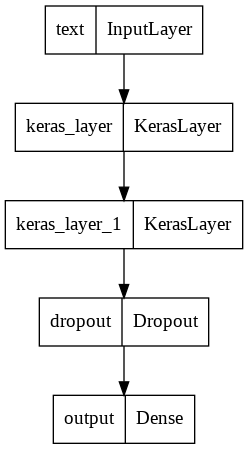

In [15]:
#Ploting Model Architecture:
tf.keras.utils.plot_model(model)

#### _Training model_

In [16]:
# start time to measure the time of the program execution
start_time = time.time()

history = model.fit(X_train, y_train, epochs=3, validation_split=0.1)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

Epoch 1/3
172/172 [==============================] - 137s 666ms/step - loss: 0.7206 - accuracy: 0.5703 - val_loss: 0.6668 - val_accuracy: 0.5796
Epoch 2/3
172/172 [==============================] - 122s 711ms/step - loss: 0.6723 - accuracy: 0.6189 - val_loss: 0.6458 - val_accuracy: 0.5961
Epoch 3/3
48/48 [==============================] - 28s 588ms/step - loss: 0.6282 - accuracy: 0.6382


[0.6282116770744324, 0.6382140517234802]



--- 431.33640575408936 seconds ---


In [17]:
y_test_arg = np.argmax(y_test, axis=1)
y_test_arg[1]
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

0

Confusion Matrix
[[835   6]
 [545 137]]
              precision    recall  f1-score   support

           0       0.61      0.99      0.75       841
           1       0.96      0.20      0.33       682

    accuracy                           0.64      1523
   macro avg       0.78      0.60      0.54      1523
weighted avg       0.76      0.64      0.56      1523



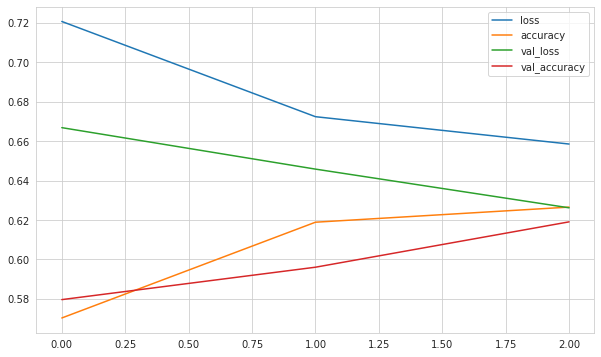

In [18]:
# This builds a graph with all the available metrics of the history.

pd.DataFrame(history.history).plot(figsize=(10,6))
plt.show()

#### __Submission__

In [19]:
submission = pd.read_csv('/content/sample_submission.csv')
submission.info()
submission

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [22]:
submission['target'] = np.argmax(model.predict(test_df['text']), axis=1)
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [24]:
submission.to_csv('/content/trial7_submission_bert.csv', index=False)